# Lego Parts in Sets - Roles Played

Requirements to run as-is:
* Google Colab and Google Drive
* Drive folder `/lego`
* Folder `/lego` contains Rebrickable [downloads](https://rebrickable.com/downloads/)
* Folder `/lego` contains a Rebrickable [API](https://rebrickable.com/api/v3/docs/) Key in the file `rbl`



# Get Data

## Google Drive

In [ ]:
UPLOAD_FOLDER = 'My Drive/lego/'
CACHE_FOLDER = 'cache/'

GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + UPLOAD_FOLDER
RAW_ROOT = FS_ROOT
CACHE_DIR = RAW_ROOT + CACHE_FOLDER

from google.colab import drive
drive.mount(GDRIVE_ROOT)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_df(fname):
  return pd.read_csv(RAW_ROOT + fname)

# Rebrickable downloads
parts_df = get_df('parts.csv').set_index('part_num')
sets_df = get_df('sets.csv').set_index('set_num')
inventories_df = get_df('inventories.csv').set_index('id')
inventory_parts_df = get_df('inventory_parts.csv')
colors_df = get_df('colors.csv').set_index('id')
minifigs_df = get_df('minifigs.csv').set_index('fig_num')

## Rebrickable API & Drive Cache

In [ ]:
import requests

RBL_HOST = 'https://rebrickable.com'
RBL_ROOT = '/api/v3/lego/'
RBL_PRE = RBL_HOST + RBL_ROOT

key_file = open(RAW_ROOT + 'rbl', 'r')
rbl_api_key = key_file.readlines()[0].strip()
auth_value = 'key ' + rbl_api_key
RBL_HDR = {'Authorization': auth_value }

def get_rbl_uri(uri):
  return requests.get(uri, headers=RBL_HDR).json()

def get_part_details(part_num):
  return requests.get(RBL_PRE + f'parts/{part_num}', headers=RBL_HDR).json()

def get_part_list_details(part_nums):
  part_nums_param_val = ','.join([str(p) for p in part_nums])
  other_params = '&inc_part_details=1&page_size=1000'
  uri = RBL_PRE + f'parts/?part_nums={part_nums_param_val}' + other_params
  return requests.get(uri, headers=RBL_HDR).json()

In [ ]:
import glob
import json
import time

def write_part_results(results, page_num):
  Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
  results_file_name = CACHE_DIR + f'results_page_{page_num:03d}.json'
  with open(results_file_name, 'w') as outfile:
    json.dump(results, outfile)

def cache_all_parts(max_pages=100):
  page_index = 0
  page_response = get_part_list_details([])
  while page_response['next'] is not None and page_index < max_pages:
    print(f'caching results page {page_index}')
    write_part_results(page_response['results'], page_index)
    page_index = page_index + 1
    # be nice to Rebrickable API
    time.sleep(10)
    page_response = get_rbl_uri(page_response['next'])

cache_exists = len(glob.glob(CACHE_DIR + '*.json')) > 0
if not cache_exists:
  cache_all_parts()
else:
  print('cache exists')

cache exists


In [ ]:
def build_cache_index():
  dir_list = sorted(glob.glob(CACHE_DIR + '*.json'))
  json_cache = []
  for f in dir_list:
    with open(f) as json_file:
      data = json.load(json_file)
      json_cache = json_cache + data
  return {p['part_num'] : p for p in json_cache}

# Set Up Data Structures

In [ ]:
jcpn = build_cache_index()

In [ ]:
sets_parts_df = pd.merge(inventory_parts_df,
                         inventories_df,
                         how='left',
                         left_on='inventory_id',
                         right_index=True)[['set_num',
                                            'part_num',
                                            'quantity',
                                            'color_id',
                                            'is_spare']]
sets_parts_df.head()

,set_num,part_num,quantity,color_id,is_spare
0,7922-1,48379c01,1,72,f
1,7922-1,48395,1,7,f
2,7922-1,stickerupn0077,1,9999,f
3,7922-1,upn0342,1,0,f
4,7922-1,upn0350,1,25,f


In [ ]:
spq = sets_parts_df.groupby(['set_num', 'part_num']).sum()['quantity']
spq_sets = spq.index.levels[0]
spq.head()

set_num  part_num
001-1    132a        4
         3020        4
         3062c       1
         3404bc01    4
         36          4
Name: quantity, dtype: int64

# Suggested Parts with Association Rule Mining

In [ ]:
sp_tuples = [tuple(spq.loc[s].index) for s in spq_sets]
sp_tuples[:3]

[('132a',
  '3020',
  '3062c',
  '3404bc01',
  '36',
  '7039',
  '7049b',
  '715',
  '741',
  '742',
  '743',
  '744'),
 ('3962a',),
 ('3962a',)]

In [ ]:
!pip install efficient-apriori
from efficient_apriori import apriori

In [ ]:
itemsets, rules = apriori(sp_tuples, min_support=0.1, min_confidence=0.6)
print(rules)
len(rules)

[{3005} -> {3004}, {3020} -> {3004}, {3004} -> {3020}, {3021} -> {3004}, {3004} -> {3021}, {3022} -> {3004}, {3004} -> {3022}, {3005} -> {3020}, {3005} -> {3022}, {3021} -> {3020}, {3020} -> {3021}, {3022} -> {3020}, {3020} -> {3022}, {3022} -> {3021}, {3021} -> {3022}, {3023} -> {3004}, {3004} -> {3023}, {3005} -> {3023}, {2431} -> {3023}, {3004} -> {6141}, {3023} -> {3020}, {3020} -> {3023}, {3666} -> {3020}, {6141} -> {3020}, {3020} -> {6141}, {3666} -> {3023}, {6141} -> {3023}, {3023} -> {6141}, {3666} -> {6141}, {2412b} -> {3023}, {2412b} -> {6141}, {3069b} -> {3004}, {3795} -> {3004}, {3023} -> {3021}, {3021} -> {3023}, {3795} -> {3021}, {3021} -> {6141}, {3023} -> {3022}, {3022} -> {3023}, {3069b} -> {3022}, {3795} -> {3022}, {6141} -> {3022}, {3022} -> {6141}, {3069b} -> {3023}, {3623} -> {3023}, {3795} -> {3023}, {3069b} -> {6141}, {3795} -> {6141}, {3710} -> {3004}, {3004} -> {3710}, {3710} -> {3020}, {3020} -> {3710}, {3795} -> {3020}, {3710} -> {3022}, {3022} -> {3710}, {37

347

In [ ]:
from PIL import Image

def transparent_part_image(part_num, content_alpha=255):
    img = Image.open(requests.get(jcpn[part_num]['part_img_url'], stream=True).raw)
    x = np.asarray(img.convert('RGBA')).copy()
    x[:, :, 3] = (content_alpha * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    return Image.fromarray(x)

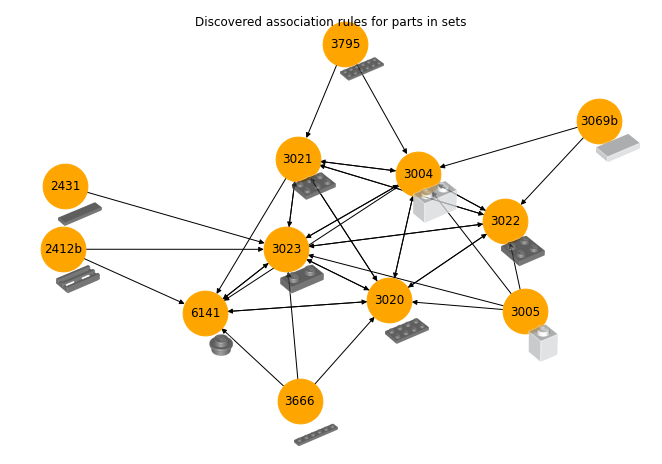

In [ ]:
import networkx as nx

gr = nx.DiGraph()
for r in rules[:40]:
  gr.add_edge(r.lhs[0], r.rhs[0])

rule_nodes = list(gr.nodes)

fig = plt.figure(figsize=(9,6))

pos = nx.kamada_kawai_layout(gr)
nx.draw(gr, pos=pos, node_size=2000, node_color='orange', with_labels=True)

for rn in rule_nodes:
  inset_x = (pos[rn][0] + 1.1) / 2.3
  inset_y = (pos[rn][1] + 0.85) / 2.3
  inset_d = 0.1
  inset = fig.add_axes([inset_x, inset_y, inset_d, inset_d])
  inset.imshow(transparent_part_image(rn, content_alpha=196))
  inset.axis('off')

fig.suptitle('Discovered association rules for parts in sets')
plt.show()